In [1]:
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html
!pip install cython pyyaml==5.1
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9 MB 23 kB/s 
     |████████████████████████████████| 4.0 MB 27.4 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.4.0+cu100 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.4.0+cu100 which is incompatible.
     |████████████████████████████████| 274 kB 11.8 MB/s 
  Created wheel for pyy

In [2]:
#import detectron2
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

model_final_997cc7.pkl: 313MB [00:14, 22.1MB/s]                           


In [4]:
!pip install face_recognition

     |████████████████████████████████| 100.1 MB 28 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=23b6670c434ad604132668c0527a3fd65ced43472e452357fe838eb13324d0e7
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [5]:
import face_recognition

In [6]:
# import some common libraries
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from google.colab import files
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline
import os, json, random
import imutils

In [7]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);  //control of video screen for live analysis output
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; 
      captureCanvas.height = 480; 
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [8]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

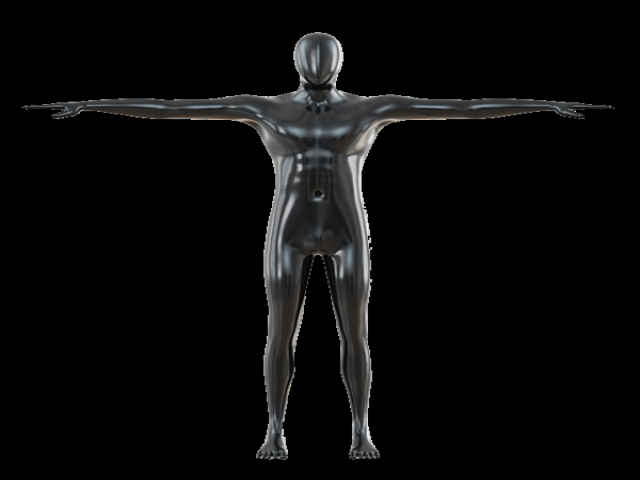

In [13]:
mannequin=cv2.imread("/content/mannequin.png")
mannequin.shape
mannequin_rgba = cv2.cvtColor(mannequin, cv2.COLOR_RGB2RGBA)
box = np.zeros([480,640,4], dtype=np.uint8) # create transparent overlay for bounding box
mannequin_rgba=cv2.resize(mannequin_rgba, box.shape[1::-1])
mannequin_rgba.shape
cv2_imshow(mannequin_rgba)

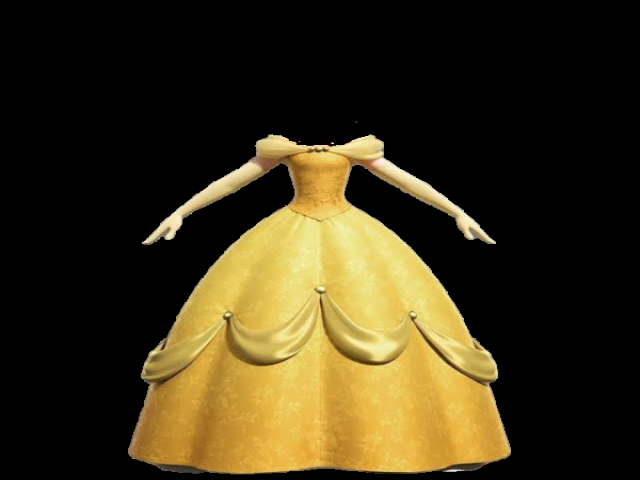

In [18]:
dress=cv2.imread("/content/dress.png")
dress.shape
dress_rgba = cv2.cvtColor(dress, cv2.COLOR_RGB2RGBA)
box = np.zeros([480,640,4], dtype=np.uint8) # create transparent overlay for bounding box
dress_rgba=cv2.resize(dress_rgba, box.shape[1::-1])
dress_rgba.shape
cv2_imshow(dress_rgba)

In [46]:
disable_face_blur=True
disable_keypoint_show=True
disable_bbox_show=True

video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 

thickness=1

font_scale = 0.5

red=(255, 0, 0)
blue=(0,0,255)
darkgoldenrod1=(255,185,15)
darkgreen=(0,100,0)
FRAME_THICKNESS = 2
MODEL = 'cnn' 

bbox_buffer_array = np.zeros([480,640,4], dtype=np.uint8) # create transparent overlay for bounding box


show_dress=False
show_mannequin=True


while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])
    outputs = predictor(frame)
    output_pred_boxes = outputs["instances"].pred_boxes #get the coordinates of bbox (tensor)
    output_pred_keypoints = outputs["instances"].pred_keypoints #get the coordinates of keypoints (tensor)

    bbox_array = np.zeros([480,640,4], dtype=np.uint8) # create transparent overlay for bounding box

    number_of_people=0
    for i in output_pred_boxes.__iter__(): #loop through the bbox found by detectron2 in the image (just in case YOLO misses something?)
          pred_box_array=i.cpu().numpy().tolist() #change tensor to a list
          if disable_bbox_show==False:
            bbox_array=cv2.rectangle(bbox_array, (int(pred_box_array[0]), int(pred_box_array[1])), (int(pred_box_array[0] + pred_box_array[2]), int(pred_box_array[1] + pred_box_array[3])), color=darkgoldenrod1, thickness=thickness)
          # bbox_array=cv2.putText(bbox_array, "person", (int(pred_box_array[0]), int(pred_box_array[1] - 5)), cv2.FONT_HERSHEY_SIMPLEX, fontScale=font_scale, color=darkgoldenrod1, thickness=2)
          number_of_people+=1

    for i in output_pred_keypoints.__iter__():
      keypoints_array=i.cpu().numpy().tolist()
      k_real=[]  
      k_arr=[]
      k=''
      for j in keypoints_array:  #x=j[0], y=j[1], probab=j[2]
        if j[2]<0.05:
          k_real.append(False)
          k_arr.append((0,0))  
          continue
        k=( int(j[0]), int(j[1] ) ) #create an array containing true/false for prob with appropriate indices
        k_real.append(True)
        k_arr.append(k)


        #if probability more or equal than
        if disable_keypoint_show==False:
          bbox_array=cv2.rectangle(bbox_array, (int(j[0]), int(j[1])), (int(j[0] + 10), int(j[1] + 10)), color=darkgoldenrod1, thickness=-1)


    # [(273, 117)]], [[(347, 114)]

    # Dress/Mannequin control
    ##########################################################################################################
    if 110<=int(k_arr[5][1])<=120 and 110<=int(k_arr[6][1])<=120:
      show_dress=True
      show_mannequin=False
    else:
      show_dress=False
      show_mannequin=True
    ##########################################################################################################


    # FACE
    ##########################################################################################################
    if disable_face_blur==False:
      locations = face_recognition.face_locations(frame, model=MODEL)
      for face_location in locations:
        top_left = (face_location[3], face_location[0]) #y,x
        bottom_right = (face_location[1], face_location[2])

        y1=face_location[0]
        y2=face_location[2]

        x1=face_location[3]
        x2=face_location[1]

        if y1>10:
          y1-=10
        
        if y2<480:
          y2+=10

        if x1>10:
          x1-=10
        
        if x2<640:
          x2+=10
          

        #crop_face=frame[face_location[0]:face_location[2],face_location[3]:face_location[1]]
        crop_face=frame[y1:y2,x1:x2]
        (h,w)=crop_face.shape[:2]
        kW = int(w / 3)
        kH = int(h / 3)
        blur_face=cv2.GaussianBlur(crop_face, (79, 71), 0)
        blur_face =  cv2.cvtColor(blur_face, cv2.COLOR_RGB2RGBA)
        #bbox_array[face_location[0]:face_location[2],face_location[3]:face_location[1], :]= blur_face
        bbox_array[y1:y2,x1:x2, :]= blur_face

        cv2.rectangle(bbox_array, top_left, bottom_right, red, FRAME_THICKNESS)
    ##########################################################################################################

    if number_of_people==0:
      bbox_array=cv2.putText(bbox_array, "Free Dress-Up App!", (5, 150), cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, color=red, thickness=2)
    else:
      bbox_array=cv2.putText(bbox_array, "Number of people detected: "+str(number_of_people), (30, 30), cv2.FONT_HERSHEY_SIMPLEX, fontScale=font_scale, color=red, thickness=2)


    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255


    # Mannequin/Dress switch
    ##########################################################################################################
    if show_mannequin==True:
      bbox_array=cv2.addWeighted(bbox_array, 0.6, mannequin_rgba, 0.4, 0)
    
    if show_dress==True:
      bbox_array=cv2.addWeighted(dress_rgba, 0.7, bbox_array, 0.3, 0)
    ##########################################################################################################


    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>